# DATA601
Joshua Black

## Starter Kit Experiments in Processing and Initial Filtering.
This notebook presents initial attempts at processing the National Library
newspaper data and experiments with topic models to do some initial filtering of the corpus
to find reporting of public events (especially lectures) and letters to the editor within the
'starter kit' corpus. Picking out these forms of writing is important to me as I believe, given an 
initial exploration of the corpus, that they are more likely to contain 
interesting philosophical writing than articles in general.

Note that, throughtout the notebook, I provide code cells to load previously generated results. Once I move to the discussion portion at the end of the notebook it will be important to load the previously generated model.

## The Starter Pack
The Starter Pack is around 2GB uncompressed and contains articles from
- Charleston Argus.
- Hot Lakes Chronicle.
- Lyell Times and Central Buller Gazette.
- Mt. Benger Mail.
- The New Zealand Gazette and Wellington Spectator.
- The Oxford Observer : and Canterbury Democrat.
- Victoria Times.

Of these, the Hot Lakes Chronicle (Rotorua and area), Mt. Bender Mail (Otago), and Oxford Observer (Canterbury) are fairly standard newspapers. The others are 'special cases' published for a very short time or very early in the time frame under interest. The following analysis filters out very short articles and advertisements. It may be that removing the 'non-standard' titles or adding more 'standard titles' would be a good idea.


## Data Processing

### Creating dataframe for corpus from ALTO/METS XML files
The Starter Pack is given uncompressed. This is not true of the full dataset
and will require a slightly different method.

We begin by importing my helper functions and reading through the Starter Pack
directories to find top-level folders for each issue in the Starter Pack.



In [44]:
from __future__ import print_function

import sys
import os
import glob
import re
import textwrap
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',
                    level=logging.INFO)

import pandas as pd

from gensim.models import LdaMulticore
from gensim import corpora

import pyLDAvis.gensim

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from IPython.display import IFrame

import NL_helpers
import NL_topicmodels

In [69]:
# Run cell to reload NL_helpers and NL_topicmodels if they have been changed.
from importlib import reload
reload(NL_helpers)
reload(NL_topicmodels)

<module 'NL_topicmodels' from '/home/joshua/Documents/Academic/MADS/DATA601/NL_topicmodels.py'>

In [46]:
# Skip the following cells by directly loading the resulting dataframe.
corpus_df = pd.read_pickle('./pickles/Starter_Items.tar.gz')

In [2]:
PATH = "./NPOD_Starter/"
path_walk = os.walk(PATH)

# Collect issue folders using regex. All are of form NEWSPAPERCODE_DATE,
# where date is in format YYYYMMDD
issue_directories = {}
for location in path_walk:
    match = re.search("[A-Z]*_\d{8}$", location[0])
    if match:
        issue_directories[match.group(0)] = location[0] + '/'

Having collected the directories for each issue, we can collect the
information we want from each. In this case, we parse the XML to produce
a Python dictionary with an article id as key, and the newspaper, date,
title, text, and tokenised text as values.

The raw text is given as a list of strings, where each string corresponds to
a 'text block' in the original newspaper scans. The tokenised text
is tokenised the python NLTK regex tokeniser and default NLTK list of
stopwords.



In [4]:
corpus_dict = {}
for issue, directory in issue_directories.items():
    newspaper = issue[:-9]
    date = issue[-8:]
    articles = NL_helpers.issue2articles(directory)
    for article_code, title_and_text in articles.items():
        article_code = article_code[7:] # remove 'MODSMD_' from article code
        item_id = '_'.join([issue, article_code])
        title, text = title_and_text
        tokenised_and_stopped = NL_helpers.tokenise_and_stop(text)
        corpus_dict[item_id] = (
            newspaper,
            date,
            title,
            text,
            tokenised_and_stopped
        )

We now convert this dictionary to a pandas dataframe. We use the object datatype
in order store Python lists within it. We save it as a pickle, also to enable
storage which respects Python datatypes.



In [14]:
corpus_df = pd.DataFrame.from_dict(
    corpus_dict,
    orient='index',
    dtype = object,
    columns=['Newspaper', 'Date', 'Title', 'Text', 'Tokenised']
    )

corpus_df.to_pickle('pickles/Starter_Items.tar.gz')
corpus_df

,Newspaper,Date,Title,Text,Tokenised
CHARG_18670302_ARTICLE1,CHARG,18670302,UNTITLED,[ago a till last Thurs- with 40oz. of gold and...,"[ago, last, thurs, 40oz, gold, went, back, sma..."
CHARG_18670309_ARTICLE1,CHARG,18670309,UNKNOWN,"[1.33 2.25 3.15 2.—Halcyon, s.s., Wing, master...","[halcyon, wing, master, jane, schooner, julia,..."
CHARG_18670309_ARTICLE2,CHARG,18670309,CHARLESTON ARGUS.,[If the Pakihi district was but well supplied ...,"[pakihi, district, well, supplied, water, nut,..."
CHARG_18670309_ARTICLE3,CHARG,18670309,UNTITLED,[Some little excitement has been evinced in re...,"[little, excitement, evinced, reference, tramw..."
CHARG_18670309_ARTICLE4,CHARG,18670309,"SATURDAY, MARCH 9, 1867. UNKNOWN","[3/u^ (Before C. Broad, Larceny. Ann Connelly,...","[broad, larceny, ann, connelly, woman, charged..."
...,...,...,...,...,...
VT_18410915_ARTICLE1,VT,18410915,Wellington Tavern.,[Edward Davis begs to inform his friends and t...,"[edward, davis, begs, inform, friends, public,..."
VT_18410915_ARTICLE2,VT,18410915,UNTITLED,[Messrs Pratt and Bevan beg respectfully to in...,"[messrs, pratt, bevan, beg, respectfully, info..."
VT_18410915_ARTICLE3,VT,18410915,UNTITLED,"[We insert the following communication by, par...","[insert, following, communication, partic, ula..."
VT_18410915_ARTICLE4,VT,18410915,UNTITLED,[The following Particulars were composed a sel...,"[following, particulars, composed, selected, m..."


### Exploring corpus using regex searches

Having set up a dataframe containing the corpus, it is worth exploring it using some more basic techniques. The following widgets allow exploration of articles containing 'philoso\*' and '\w\*ism'. If topic models don't do better than simple searches, then something is going wrong.

First, 'philoso*':

In [47]:
philoso_indices = NL_helpers.search_text(corpus_df, 'philoso*')
print(f'Article matches: {len(philoso_indices)}')
interact(NL_helpers.html_text, index=philoso_indices, boldface=fixed('philoso\\w*'), dataframe=fixed(corpus_df))

Article matches: 99


interactive(children=(Dropdown(description='index', options=('HLC_18950215_ARTICLE19', 'HLC_18950529_ARTICLE20…

<function NL_helpers.html_text(index, dataframe, boldface=None)>

The following articles seem particularly of note:
 - **HLC_18950215_ARTICLE19**: Philosophy in book review - Sir Edward Arnold on relationship between modern astronomical discoveries and religion (more general themes: pessimism, anarchism, materialism. Seems like a harmony of science and religion approach 'in light of the stately march of the stars' etc.
 - *HLC_18950918_ARTICLE8* First order philosophy by 'Lady Cook' https://en.wikipedia.org/wiki/Tennessee_Claflin (from US)
 - *LTCBG_18860501_ARTICLE7*: That New Zealand thought of as best chance for 'the English nation' to produce 'great men' - 'English poets, artists, philosophers, statesmen, and soldiers'...
 - *LTCBG_18860724_ARTICLE6*: Notes from Nelson - creation of debating club to discussion social and moral philosophy - very dismissive report.
 - *MTBM_18979730_ARTICLE1*: news of a Christchurch metaphysical club set up to encourage the kind of thing James called mind-cure (perhaps they're in to 'Christian Science'?)
 - *NZGWS_18420702_ARTICLE4*: Very early lecture report. George White at the Mechanic's Institute (Auckland?) on temperence. 
 - *NZGWS_18430527_ARTICLE6*: Some first order phil? Early. Some 'meaning of life' material (purpose of humans: self perfection).
 - *OO_18910214_ARTICLE3* - Problems of labour saving and automation reducing the number of jobs. Praise of those breaking looms. Discussion of socialism.
 - **OO_18920109_ARTICLE7**: This is exactly the kind of item I want to do something with. In this case a letter to the editor about recent lectures and about intellectual life in Oxford (Canterbury). Religion and Science the issue (with mention to Mr Gladstone's book - possibly 'The Impregnable Rock of Holy Scripture' (https://archive.org/details/a583189400gladuoft)
 - **OO_18921224_ARTICLE2**: Another excellent piece for what I'm after. A report of a public debate in Oxford on existence of God.
 - *OO_18940714_ARTICLE15*: print of short set of questions by Berkeley on the idea of a National Bank. (PRINTED IN MULTIPLE ISSUES OF THE PAPER)
 - *OO_18941124_ARTICLE1*: Some first-order liberal political philosophy. On whether not changing mind is an intellectual virtue.
 - *OO_18951019_ARTICLE7*: Exp of mining as introducing new theoretical problems, currently merely philosophical, hoped to become practical scientific solutions to problem of chance in mining. 
 - *OO_18960307_ARTICLE2*: More Lady Cook. An essay on distinction between contentment and resignation.
 - *OO_18960418_ARTICLE6*: Seems to be local discussion of 'individual immortality' - as in, is there an immortal soul over and against the mortal body. Doesn't indicate where text comes from. Not a lecture report.
 - **OO_18961226_ARTICLE3**: Article written by Lady Cook *for the Observer* - encouragement to young women to 'serious reading' including philosophy. (ditto OO_18970102_ARTICLE10, OO_18971106_ARTICLE11, OO_18980122_ARTICLE5)
 - *OO_18970130_ARTICLE8* - Short quote on theodicy.
 - *OO_18971127_ARTICLE3* - Report of lecture in Oxford town hall by mind cure practitioner.

Second, '\w\*ism':

In [48]:
ism_indices = NL_helpers.search_text(corpus_df, '\\w{4,}ism')
print(f'Article matches: {len(ism_indices)}')
interact(NL_helpers.html_text, index=ism_indices, boldface=fixed('\\w{4,}ism'), dataframe=fixed(corpus_df))

Article matches: 647


interactive(children=(Dropdown(description='index', options=('CHARG_18670406_ARTICLE3', 'CHARG_18670427_ARTICL…

<function NL_helpers.html_text(index, dataframe, boldface=None)>

647 results is a large proportion of the corpus. Scanning through the articles very quickly, I found the following:
 - *HLC_18950215_ARTICLE12*: Discussion of recent article (in magazine) arguing for socialism - 'Rousseauism Revived'. 
 - *MTBM_18810302_ARTICLE12*: Public debates on role or not or 'Bible in schools'.
 - *MTBM_18961113_ARTICLE16*: Shows a problem with my function for displaying articles - sometimes OCR errors produce HTML tags!
 - *OO_18910221_ARTICLE9*: Letter to editor on meaning of 'socialism'. (In general, plenty on 'socialism' in OO.
 - *OO_18989226_ARTICLE2*: Socialism vs individualism
 - *OO_18970529_ARTICLE1*: Socialism tied to more general attitude to evolution.

We might also be interested in the use of academic titles. The following interactive allows for exploration of articles containing 'Professor':

In [49]:
acad_indices = NL_helpers.search_text(corpus_df, 'professor')
print(f'Article matches: {len(acad_indices)}')
interact(NL_helpers.html_text, index=acad_indices, boldface=fixed('professor'), dataframe=fixed(corpus_df))

Article matches: 26


interactive(children=(Dropdown(description='index', options=('HLC_18950417_ARTICLE16', 'HLC_18950424_ARTICLE18…

<function NL_helpers.html_text(index, dataframe, boldface=None)>

*OO_18920102_ARTICLE6* Another letter on 'Mr Collin's lecture'

Finally, I also examine what comes up with the search 'lectur\*':

In [50]:
lect_indices = NL_helpers.search_text(corpus_df, 'lectur*')
print(f'Article matches: {len(lect_indices)}')
interact(NL_helpers.html_text, index=lect_indices, boldface=fixed('lecture\\w*'), dataframe=fixed(corpus_df))
# TODO: Figure out how to fix size of output window.

Article matches: 359


interactive(children=(Dropdown(description='index', options=('CHARG_18670410_ARTICLE3', 'HLC_18950227_ARTICLE1…

<function NL_helpers.html_text(index, dataframe, boldface=None)>

- *OO_18970918_ARTICLE4*: report of lecture on whether modern person can believe in hell (quotes Oliver Wendell Holmes). 
- **OO_18961010_ARTICLE9**: Mentions address on whether Bible to be taken literally, science against, e.g. the flood. Lecture report, even if not very detailed. I'd like to find more of these in the corpus.
- **OO_18950330_ARTICLE4**: Another letter on Mr Collins' lecture (with note that they can't accept any more long letters on such topics) (More like this here)
- **OO_18950309_ARTICLE3**: Report on the lecture itself *'why the best men leave the church'.
- *OO_18920618_ARTICLE8*: Announcment of mutual improvement and debating society.


## Initial Topic Model Using Gensim

### Model creation
Earlier experiments have shown that having a bunch of empty documents around
is not good for producing interesting models. I found an interesting looking
topic filled with words in te reo, but was disappointed to find it represented
a very small number of actual documents and a huge number of empty ones.
I will use two filtering steps. First, I filter out those articles which
have less than 20 words after tokenising.



In [51]:
cutoff = 20
filtered_corpus_df = corpus_df[corpus_df['Tokenised'].apply(lambda x: len(x) >= cutoff)]

We then create a dictionary for applying topic models with Gensim.

In [52]:
# Skip dictionary creation by loading pre-made dictionary
dictionary = corpora.Dictionary.load('dictionaries/starter_pack.dict')

2020-12-15 19:19:13,041 : INFO : loading Dictionary object from dictionaries/starter_pack.dict
2020-12-15 19:19:13,068 : INFO : loaded dictionaries/starter_pack.dict


In [10]:
minimum_in_docs = 5
dictionary = corpora.Dictionary(filtered_corpus_df['Tokenised'])
dictionary.filter_extremes(no_below=minimum_in_docs, no_above=0.5)
dictionary.compactify()

In [10]:
dictionary.save('dictionaries/starter_pack.dict')

NameError: name 'dictionary' is not defined

This is enough to use the `NL_corpus` class provided in `NL_topicmodels.py`. This generates a bag of words representation of each article on initialisation.

In [53]:
starter_corpus = NL_topicmodels.NL_corpus(filtered_corpus_df, dictionary)
starter_corpus.items

,Newspaper,Date,Title,Text,Tokenised,BOW
CHARG_18670302_ARTICLE1,CHARG,18670302,UNTITLED,[ago a till last Thurs- with 40oz. of gold and...,"[ago, last, thurs, 40oz, gold, went, back, sma...","[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1..."
CHARG_18670309_ARTICLE1,CHARG,18670309,UNKNOWN,"[1.33 2.25 3.15 2.—Halcyon, s.s., Wing, master...","[halcyon, wing, master, jane, schooner, julia,...","[(27, 1), (49, 1), (167, 1), (244, 1), (342, 2..."
CHARG_18670309_ARTICLE2,CHARG,18670309,CHARLESTON ARGUS.,[If the Pakihi district was but well supplied ...,"[pakihi, district, well, supplied, water, nut,...","[(10, 1), (11, 1), (29, 1), (37, 1), (48, 1), ..."
CHARG_18670309_ARTICLE3,CHARG,18670309,UNTITLED,[Some little excitement has been evinced in re...,"[little, excitement, evinced, reference, tramw...","[(8, 1), (13, 2), (15, 1), (47, 1), (48, 2), (..."
CHARG_18670309_ARTICLE4,CHARG,18670309,"SATURDAY, MARCH 9, 1867. UNKNOWN","[3/u^ (Before C. Broad, Larceny. Ann Connelly,...","[broad, larceny, ann, connelly, woman, charged...","[(132, 1), (170, 1), (230, 1), (244, 1), (371,..."
...,...,...,...,...,...,...
OO_18990909_ARTICLE11,OO,18990909,OXFOED ROAD BOARD.,[The ordinary meeting of the Board was held on...,"[ordinary, meeting, board, held, welnesday, se...","[(6, 3), (71, 1), (120, 1), (125, 2), (139, 1)..."
VT_18410915_ARTICLE1,VT,18410915,Wellington Tavern.,[Edward Davis begs to inform his friends and t...,"[edward, davis, begs, inform, friends, public,...","[(120, 1), (135, 1), (139, 1), (143, 1), (147,..."
VT_18410915_ARTICLE2,VT,18410915,UNTITLED,[Messrs Pratt and Bevan beg respectfully to in...,"[messrs, pratt, bevan, beg, respectfully, info...","[(86, 1), (105, 1), (122, 1), (147, 1), (170, ..."
VT_18410915_ARTICLE3,VT,18410915,UNTITLED,"[We insert the following communication by, par...","[insert, following, communication, partic, ula...","[(9, 1), (11, 1), (48, 2), (54, 1), (97, 1), (..."


 We filter again to remove any article whose BOW representation is less than 20 words.

In [15]:
starter_corpus.items = starter_corpus.items[starter_corpus.items['BOW'].apply(lambda x: len(x) >= cutoff)]
len(starter_corpus.items)

10183

The output above shows that we have 10183 remaining documents.

The distribution between newspapers is as follows:

In [11]:
starter_corpus.items['Newspaper'].value_counts()

OO       4544
NZGWS    2748
HLC      1471
MTBM      847
LTCBG     512
CHARG      57
VT          4
Name: Newspaper, dtype: int64

We run a topic model on these using `LdaMulticore` from `gensim`. 

In [20]:
# The rule of thumb for setting workers is cores - 1. 
starter_model = LdaMulticore(
    starter_corpus,
    num_topics= 50,
    workers = 15,
    chunksize = 220,
    id2word=starter_corpus.dictionary,
    iterations = 500,
    passes = 25,
    eval_every = 100
)

2020-12-11 10:22:06,044 : INFO : using symmetric alpha at 0.02
2020-12-11 10:22:06,045 : INFO : using symmetric eta at 0.02
2020-12-11 10:22:06,049 : INFO : using serial LDA version on this node
2020-12-11 10:22:06,145 : INFO : running online LDA training, 50 topics, 25 passes over the supplied corpus of 10183 documents, updating every 3300 documents, evaluating every ~10183 documents, iterating 500x with a convergence threshold of 0.001000
2020-12-11 10:22:06,146 : INFO : training LDA model using 15 processes
2020-12-11 10:22:06,280 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #220/10183, outstanding queue size 1
2020-12-11 10:22:06,302 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #440/10183, outstanding queue size 2
2020-12-11 10:22:06,303 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #660/10183, outstanding queue size 3
2020-12-11 10:22:06,304 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #880/10183, outst

The output above shows that we obtain a stablish perplexity in the low 500's from around pass 15 onwards.

In [29]:
starter_model.save('lda_models/starter_model_50')

2020-12-11 10:35:19,819 : INFO : saving LdaState object under lda_models/starter_model_50.state, separately None
2020-12-11 10:35:19,876 : INFO : saved lda_models/starter_model_50.state
2020-12-11 10:35:19,888 : INFO : saving LdaMulticore object under lda_models/starter_model_50, separately ['expElogbeta', 'sstats']
2020-12-11 10:35:19,889 : INFO : storing np array 'expElogbeta' to lda_models/starter_model_50.expElogbeta.npy
2020-12-11 10:35:19,913 : INFO : not storing attribute id2word
2020-12-11 10:35:19,914 : INFO : not storing attribute dispatcher
2020-12-11 10:35:19,914 : INFO : not storing attribute state
2020-12-11 10:35:19,916 : INFO : saved lda_models/starter_model_50


In [54]:
# Load premade model. 
# If you have already saved your own model, my previously generated model can be loaded 
# at the path 'lda_models/starter_model_50_11-12-2020'
starter_model = LdaMulticore.load('lda_models/starter_model_50')

2020-12-15 19:19:31,485 : INFO : loading LdaMulticore object from lda_models/starter_model_50
2020-12-15 19:19:31,489 : INFO : loading expElogbeta from lda_models/starter_model_50.expElogbeta.npy with mmap=None
2020-12-15 19:19:31,496 : INFO : setting ignored attribute id2word to None
2020-12-15 19:19:31,497 : INFO : setting ignored attribute dispatcher to None
2020-12-15 19:19:31,499 : INFO : setting ignored attribute state to None
2020-12-15 19:19:31,500 : INFO : loaded lda_models/starter_model_50
2020-12-15 19:19:31,501 : INFO : loading LdaState object from lda_models/starter_model_50.state
2020-12-15 19:19:31,545 : INFO : loaded lda_models/starter_model_50.state


### Visualisation and global discussion.

This model can be visualised using `pyLDAvis` as follows (note that the topic numbers in the visualisation do not correspond to the topic numbers given by gensim.

In [56]:
vis = pyLDAvis.gensim.prepare(
    starter_model, 
    starter_corpus, 
    dictionary=starter_corpus.dictionary,
    sort_topics=False
)
pyLDAvis.save_html(vis, 'visualisations/starter_model_50_LDAvis.html')

In [58]:
pyLDAvis.display(vis)

*NB: the following discussion relies on the model I have generated. If you have generated your own, you will need to uncomment and run the following cell.*

A few topics in the above are interesting when looking for philosophy in public lectures, letters to the editor, and first-order publications.

In terms of *public lectures*, topic 2 in the visualisation seems to indicate public events including meetings, church services and lectures. The words for days of the week, the use of 'visit' etc, suggest that this topic *might* indicate reporting of public events. 14 may also be of interest, but seems to concern council meetings more than does topic 2 (this is partically based off a sense of the number of local council and road board meetings reported in the Oxford Observer, which makes up a large proportion of this starter dataset).

In terms of *letters to the editor*, topic 44 may be of interest (here, I'm going off the prominence of 'sir' and 'paper'. 

Topic 31 looks encouraging for both public lectures and letter to the editor. The prominence of 'public', 'people', 'society', 'church',  and 'presenct' are particularly interesting. We also see indications of intellectual content with 'school', 'education' and 'political'. 'Sir', 'would', and 'may' encourage the thought that there might also be letter content here as well.

Topic 29 has indications of public events, but the prominence of'race', 'song', 'band', 'weather' suggests we're getting something more like entertainment. On the other hand, I have discovered meeting reports of 'women's events' in which intellectual material is discussed amid a collection of words that looks quite similar to topic 29. It would be unwise to not have a look at some of the documents high in topic 29.

In [71]:
# To load previously saved visualisation
# IFrame(src='visualisations/starter_model_50_11-12-2020_LDAvis.html', width=1800, height=900) # Sorry this is ugly...

To investigate the items in these topics in more details, I will enrich the corpus dataframe with columns containing the proportion of each topic assigned to each article.

In [62]:
starter_corpus.items['Modelled'] = starter_model[starter_corpus]

In [64]:
starter_corpus_enriched = NL_topicmodels.topic_proportions(starter_corpus.items, starter_model.num_topics)

In [65]:
starter_corpus_enriched

,Newspaper,Date,Title,Text,Tokenised,BOW,Modelled,Topic 1,Topic 2,Topic 3,...,Topic 41,Topic 42,Topic 43,Topic 44,Topic 45,Topic 46,Topic 47,Topic 48,Topic 49,Topic 50
CHARG_18670302_ARTICLE1,CHARG,18670302,UNTITLED,[ago a till last Thurs- with 40oz. of gold and...,"[ago, last, thurs, 40oz, gold, went, back, sma...","[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1...","[(0, 0.016443148), (2, 0.012724828), (4, 0.022...",0.016443,0.000000,0.012725,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.070626,0.0
CHARG_18670309_ARTICLE1,CHARG,18670309,UNKNOWN,"[1.33 2.25 3.15 2.—Halcyon, s.s., Wing, master...","[halcyon, wing, master, jane, schooner, julia,...","[(27, 1), (49, 1), (167, 1), (244, 1), (342, 2...","[(8, 0.07677733), (10, 0.3514803), (15, 0.0271...",0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.284708,0.0,0.000000,0.000000,0.0
CHARG_18670309_ARTICLE2,CHARG,18670309,CHARLESTON ARGUS.,[If the Pakihi district was but well supplied ...,"[pakihi, district, well, supplied, water, nut,...","[(10, 1), (11, 1), (29, 1), (37, 1), (48, 1), ...","[(4, 0.20258504), (9, 0.18228263), (21, 0.0682...",0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.074853,0.0
CHARG_18670309_ARTICLE3,CHARG,18670309,UNTITLED,[Some little excitement has been evinced in re...,"[little, excitement, evinced, reference, tramw...","[(8, 1), (13, 2), (15, 1), (47, 1), (48, 2), (...","[(1, 0.05285612), (9, 0.093635), (13, 0.481819...",0.000000,0.052856,0.000000,...,0.000000,0.044001,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
CHARG_18670309_ARTICLE4,CHARG,18670309,"SATURDAY, MARCH 9, 1867. UNKNOWN","[3/u^ (Before C. Broad, Larceny. Ann Connelly,...","[broad, larceny, ann, connelly, woman, charged...","[(132, 1), (170, 1), (230, 1), (244, 1), (371,...","[(41, 0.1654606), (48, 0.8136571)]",0.000000,0.000000,0.000000,...,0.000000,0.165461,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.813657,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OO_18990909_ARTICLE11,OO,18990909,OXFOED ROAD BOARD.,[The ordinary meeting of the Board was held on...,"[ordinary, meeting, board, held, welnesday, se...","[(6, 3), (71, 1), (120, 1), (125, 2), (139, 1)...","[(5, 0.011164617), (11, 0.75540495), (17, 0.01...",0.000000,0.000000,0.000000,...,0.000000,0.000000,0.049046,0.0,0.000000,0.000000,0.0,0.010579,0.000000,0.0
VT_18410915_ARTICLE1,VT,18410915,Wellington Tavern.,[Edward Davis begs to inform his friends and t...,"[edward, davis, begs, inform, friends, public,...","[(120, 1), (135, 1), (139, 1), (143, 1), (147,...","[(7, 0.29115763), (10, 0.028505016), (20, 0.02...",0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.040444,0.000000,0.0,0.098405,0.000000,0.0
VT_18410915_ARTICLE2,VT,18410915,UNTITLED,[Messrs Pratt and Bevan beg respectfully to in...,"[messrs, pratt, bevan, beg, respectfully, info...","[(86, 1), (105, 1), (122, 1), (147, 1), (170, ...","[(4, 0.3513554), (15, 0.0430932), (24, 0.41573...",0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.056125,0.000000,0.0,0.000000,0.000000,0.0
VT_18410915_ARTICLE3,VT,18410915,UNTITLED,"[We insert the following communication by, par...","[insert, following, communication, partic, ula...","[(9, 1), (11, 1), (48, 2), (54, 1), (97, 1), (...","[(4, 0.15978889), (14, 0.019233534), (19, 0.01...",0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0


In [66]:
starter_corpus_enriched.to_pickle('pickles/starter_corpus_enriched.tar.gz')

It may be useful to refer to a more straightforward list of topic keywords.

In [61]:
tops_and_kws = NL_topicmodels.topics_and_keywords(starter_model)
tops_and_kws

{'Topic 1': 'match, team, play, game, played, club, good, ball, saturday, points',
 'Topic 2': 'oxford, church, last, meeting, evening, sunday, held, next, monday, rev',
 'Topic 3': 'shall, claim, prospecting, warden, may, grant, area, ground, workings, granted',
 'Topic 4': 'london, sir, lord, queen, prince, two, killed, three, york, troops',
 'Topic 5': 'land, would, may, large, well, good, many, great, much, new',
 'Topic 6': 'bank, directors, shares, company, shareholders, capital, banks, cent, 000, notes',
 'Topic 7': 'license, standard, licensing, licenses, drink, liquor, committee, possible, prohibition, coal',
 'Topic 8': 'new, zealand, company, england, south, london, government, british, land, sydney',
 'Topic 9': 'horse, horses, trap, mile, yrs, owner, mare, 7st, bst, handicap',
 'Topic 10': 'gold, stone, feet, mining, work, level, good, reef, last, battery',
 'Topic 11': 'cases, casks, case, bags, boxes, flour, barrels, oil, cask, sugar',
 'Topic 12': 'board, meeting, commi

### Topics of interest from visualisation and keywords.

To work out how many articles and what kind of cut off in terms of topic proportions we might be interested in, we can generate some histograms.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fac8522e950>,
      dtype=object)

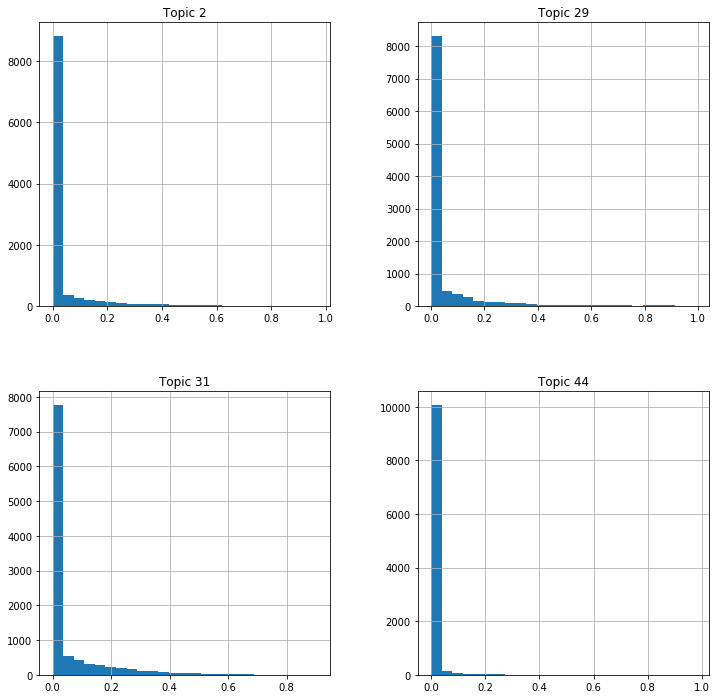

In [68]:
starter_corpus_enriched.hist(column=['Topic 2', 'Topic 31', 'Topic 29', 'Topic 44'], figsize=[12, 12], bins=25)

The histograms above give some indication of what kind of cut-off we might be interested in for allowing items in to the next stage. As an initial test, we can look at items popular in topic 2 with a cut-off of a topic proportion of 0.2:

In [72]:
topic_2_df = NL_topicmodels.topic_df(starter_corpus_enriched, 'Topic 2', 0.2)
topic_2_df

,Newspaper,Date,Title,Text,Tokenised,Topic 2
OO_18961024_ARTICLE16,OO,18961024,OXFORD.,[It is to be hoped that the Brass Band m cours...,"[hoped, brass, band, course, formation, entire...",0.967307
HLC_18960617_ARTICLE12,HLC,18960617,UNTITLED,"[Music, Music, Music :—A choice selec tion of ...","[music, music, music, choice, selec, tion, lat...",0.961701
OO_18960229_ARTICLE9,OO,18960229,LOCAL and GENERAL,[Limelight Service. — The Salvation Army gave ...,"[limelight, service, salvation, army, gave, li...",0.947149
OO_18921203_ARTICLE13,OO,18921203,DIVINE SERVICES.,"[SUNOAY NEXT. U. M. F. Church, West Oxford, 11...","[sunoay, next, church, west, oxford, rev, benn...",0.945546
OO_18980402_ARTICLE11,OO,18980402,LOCAL and GENERAL,[Note. — When town travellers as for printing ...,"[note, town, travellers, printing, orders, bus...",0.938010
...,...,...,...,...,...,...
MTBM_18961231_ARTICLE9,MTBM,18961231,Christmas Day at the Churches.,[An ordinary service was held at. St. Jaines C...,"[ordinary, service, held, jaines, church, engl...",0.200673
HLC_18960429_ARTICLE5,HLC,18960429,SCHOOL COMMITTEE ELECTION.,[A meeting of residents took place in the Scho...,"[meeting, residents, took, place, schoolroom, ...",0.200459
MTBM_18961224_ARTICLE7,MTBM,18961224,Cromwell Notes.,"[(Own Correspondent.) "" Yours Truly "" had the ...","[correspondent, truly, pleagure, witnessing, f...",0.200436
OO_18891026_ARTICLE16,OO,18891026,CUST.,"[Cricket practice is being proceeded with, the...","[cricket, practice, proceeded, genuine, cricke...",0.200400


In [73]:
interact(NL_helpers.print_text, index=topic_2_df.index, dataframe=fixed(topic_2_df))

interactive(children=(Dropdown(description='index', options=('OO_18961024_ARTICLE16', 'HLC_18960617_ARTICLE12'…

<function NL_helpers.print_text(index, dataframe)>

The following, picked out by keyword search earlier, is of note:
 - *OO_18961010_ARTICLE9* - religion and science, abolution and slavery, 'The lecturer at the conclusion of his address invited discussion, but no one took up the challenge, the poor old Bobk[sic] could not find a champion m[sic] the Hall.

We now do the same for topic 29.

In [74]:
topic_29_df = NL_topicmodels.topic_df(starter_corpus_enriched, 'Topic 29', 0.2)

In [75]:
interact(NL_helpers.print_text, index=topic_29_df.index, dataframe=fixed(topic_29_df))

interactive(children=(Dropdown(description='index', options=('MTBM_18971112_ARTICLE6', 'OO_18910502_ARTICLE6',…

<function NL_helpers.print_text(index, dataframe)>

As expected this is largely about entertainment. It might be worth aggregating the number of reports like this to compare them to, say, public lectures as a sign of the relative interest in the two kinds of event.

In [77]:
topic_31_df = NL_topicmodels.topic_df(starter_corpus_enriched, 'Topic 31', 0.2)
topic_31_df

,Newspaper,Date,Title,Text,Tokenised,Topic 31
OO_18970821_ARTICLE2,OO,18970821,NEW JOURNAL.,"[The first number of ""The Socialist"" come to h...","[first, number, socialist, hand, contatns, wel...",0.904200
HLC_18950424_ARTICLE15,HLC,18950424,THE PROPOSED REUNION OF THE CHURCHES.,[There is naturally much controversy on the ab...,"[naturally, much, controversy, bubject, englan...",0.893360
OO_18980226_ARTICLE8,OO,18980226,THE SOCIALIST CHURCH.,"[■~. . 3 ,J)EFINITIP^S. ; * 'There is a true C...","[efinitip, true, church, wherever, hand, meets...",0.873240
OO_18970710_ARTICLE1,OO,18970710,The Oxford Obserber. PUBLISHED WEEKLY. SATUR...,"['• Are '""""the English people really going bac...","[english, people, really, going, back, pol, if...",0.847865
NZGWS_18410116_ARTICLE7,NZGWS,18410116,"TO THE EDITOR OF THE ""NEW ZEALAND GAZETTE.""","[Sm, — The first great requisite of national p...","[first, great, requisite, national, prosperity...",0.807670
...,...,...,...,...,...,...
OO_18980122_ARTICLE10,OO,18980122,LYTTELTON TIMES Monday 17th,"[THE OXFORD. FIRES. TO THE EDITOR. Sir, — As t...","[oxford, fires, editor, sir, special, commissi...",0.200640
OO_18890907_ARTICLE18,OO,18890907,A HINT FOR RANGIORA.,"[To the Editor oj ' The Observer.' Sir, — Will...","[editor, observer, sir, allow, medium, interes...",0.200637
OO_18940901_ARTICLE17,OO,18940901,UNTITLED,[Having kept silent on this subject so long wh...,"[kept, silent, subject, long, sir, robert, rai...",0.200624
OO_18970619_ARTICLE7,OO,18970619,ST. ALBANS WESLEYAN LITERARY AND DEBATING SO...,[The usual fortnightly meeting of the St. Alba...,"[usual, fortnightly, meeting, albans, wesleyan...",0.200202


In [38]:
interact(NL_helpers.print_text, index=topic_30_df.index, dataframe=fixed(topic_30_df))

interactive(children=(Dropdown(description='index', options=('OO_18970821_ARTICLE2', 'HLC_18950424_ARTICLE15',…

<function NL_helpers.print_text(index, dataframe)>

In [39]:
topic_43_df = NL_topicmodels.topic_df(starter_corpus_enriched, 'Topic 43', 0.1)
topic_43_df

,Newspaper,Date,Title,Text,Topic 43
NZGWS_18410710_ARTICLE4,NZGWS,18410710,AGENTS FOR THIS PAPER.,"[Mr. R. BARRETT New Plymouth, Taranalci Mr. H ...",0.977207
NZGWS_18420618_ARTICLE4,NZGWS,18420618,AGENTS FOR THIS PAPER.,[Mr. BURCKA.M Petoni. Mr. F. G. MOO HE Nelson ...,0.971173
NZGWS_18411117_ARTICLE6,NZGWS,18411117,AGENTS FOR THIS PAPER.,[Mr. BURCH AM » Petoni. Mr. R. BARRETT » New P...,0.970302
NZGWS_18411013_ARTICLE3,NZGWS,18411013,AGENTS FOR THIS PAPER.,[Mr. BURCH AM Petoni. Mr. It. BARRETT New Plym...,0.969374
NZGWS_18411204_ARTICLE7,NZGWS,18411204,AGENTS FOR THIS PAPER.,"[Mr. BURCHAMr. Petoni. ,-; - Mr. R. BARRETT Ne...",0.969374
...,...,...,...,...,...
NZGWS_18440306_ARTICLE5,NZGWS,18440306,THE NATIVES.,"[To the Editor cf the "" New Zealand Gazette an...",0.105134
OO_18960516_ARTICLE4,OO,18960516,View Hill.,"[TO THE EDITOR. Sir, —A short time ago, you pu...",0.103897
HLC_18951030_ARTICLE1,HLC,18951030,THE HOT LAKES CHRONICLE AND Tourists' Journal....,[The reports and specifications regard ing the...,0.103631
LTCBG_18860116_ARTICLE9,LTCBG,18860116,MAIL NEWS.,[The estimate of the final result of the elect...,0.103109


In [40]:
interact(NL_helpers.print_text, index=topic_43_df.index, dataframe=fixed(topic_43_df))

interactive(children=(Dropdown(description='index', options=('NZGWS_18410710_ARTICLE4', 'NZGWS_18420618_ARTICL…

<function NL_helpers.print_text(index, dataframe)>

### Topics of interest from highlighted documents.

Another way to determine which topics we should be interested in is to look at the topic distributions for the articles which have been singled out from the corpus by keyword searches:

In [70]:
key_articles = [
    'OO_18920109_ARTICLE7', # Letter to editor concerning intellectual life in Oxford, comment on recent lecture.
    'OO_18921224_ARTICLE2', # Report on local debate on existence of God.
    'OO_18961226_ARTICLE3', # A 'Lady Cook' piece
    'HLC_18950215_ARTICLE19', # Philosophical book review.
    'OO_18989226_ARTICLE2', # Socialism vs individualism.
    'OO_18961010_ARTICLE9', # Low information lecture report.
    'OO_18950309_ARTICLE3', # Lecture report.
    'OO_18950330_ARTICLE4' # Letter on lecture just listed.
]
interact(
    NL_topicmodels.topic_proportions_chart, 
    index_label=key_articles, 
    dataframe=fixed(starter_corpus.items)
)
# Find some way to make colours common throughout?

interactive(children=(Dropdown(description='index_label', options=('OO_18920109_ARTICLE7', 'OO_18921224_ARTICL…

<function NL_topicmodels.topic_proportions_chart(index_label, dataframe)>

The most obvious thing that sticks out here is the prominence of topic 22 in all of the articles (with slightly less for article 9 (the 'low information' report.

We also see quite a lot of topic 31, discussed above. We also see quite a bit of topic 32. 

I'll now have a quick look at topics 22 and 32, following the same pattern as above.

In [ ]:
starter_corpus_enriched.hist(column=['Topic 22', 'Topic 32'], figsize=[12, 6], bins=25)

Looking at the histograms, I will start with initial cuttoffs of 0.3 for Topic 22 and 0,2 for Topic 32.

In [ ]:
topic_22_df = NL_topicmodels.topic_df(starter_corpus_enriched, 'Topic 22', 0.3)
interact(NL_helpers.html_text, boldface=fixed(None), index=topic_22_df.index, dataframe=fixed(topic_22_df))

What a strange collection. Some themes: there's quite a bit of poetry here along with strange aphorisms, and some of the articles I highlighted earlier.

In [ ]:
topic_32_df = NL_topicmodels.topic_df(starter_corpus_enriched, 'Topic 32', 0.2)
interact(NL_helpers.html_text, boldface=fixed(None), index=topic_32_df.index, dataframe=fixed(topic_32_df))

This is basically a box for NZGWS articles. Lots of legal and governmental language though. This kind of language is present in other areas where deliberation is important.

### Topic Model for Documents High in Topic 30

Why not a topic model for articles with topic 30 above 0.2? Here goes?

In [45]:
topic_30_df

,Newspaper,Date,Title,Text,Tokenised,Topic 30
OO_18970821_ARTICLE2,OO,18970821,NEW JOURNAL.,"[The first number of ""The Socialist"" come to h...","[first, number, socialist, hand, contatns, wel...",0.904198
HLC_18950424_ARTICLE15,HLC,18950424,THE PROPOSED REUNION OF THE CHURCHES.,[There is naturally much controversy on the ab...,"[naturally, much, controversy, bubject, englan...",0.893396
OO_18980226_ARTICLE8,OO,18980226,THE SOCIALIST CHURCH.,"[■~. . 3 ,J)EFINITIP^S. ; * 'There is a true C...","[efinitip, true, church, wherever, hand, meets...",0.873234
OO_18970710_ARTICLE1,OO,18970710,The Oxford Obserber. PUBLISHED WEEKLY. SATUR...,"['• Are '""""the English people really going bac...","[english, people, really, going, back, pol, if...",0.847901
NZGWS_18410116_ARTICLE7,NZGWS,18410116,"TO THE EDITOR OF THE ""NEW ZEALAND GAZETTE.""","[Sm, — The first great requisite of national p...","[first, great, requisite, national, prosperity...",0.807582
...,...,...,...,...,...,...
NZGWS_18440117_ARTICLE8,NZGWS,18440117,MECHANICS' INSTITUTE.,[A meeting of the Committee of this body took ...,"[meeting, committee, body, took, place, monday...",0.200630
OO_18940901_ARTICLE17,OO,18940901,UNTITLED,[Having kept silent on this subject so long wh...,"[kept, silent, subject, long, sir, robert, rai...",0.200588
OO_18950119_ARTICLE9,OO,18950119,OXFORD SPORTS.,[Sir. — Kindly allow me a small space in your ...,"[sir, kindly, allow, small, space, paper, pass...",0.200277
OO_18970619_ARTICLE7,OO,18970619,ST. ALBANS WESLEYAN LITERARY AND DEBATING SO...,[The usual fortnightly meeting of the St. Alba...,"[usual, fortnightly, meeting, albans, wesleyan...",0.200195


In [23]:
# Redoing conversion to bag of words is inefficient here. But perhaps I 
# will want to change dictionaries?
topic_30_corpus = NL_topicmodels.NL_corpus(topic_30_df, dictionary)

NameError: name 'topic_30_df' is not defined

In [50]:
topic_30_model = LdaMulticore(
    topic_30_corpus,
    num_topics = 75,
    workers = 15,
    chunksize = 50,
    id2word=topic_30_corpus.dictionary,
    iterations = 500,
    passes = 50,
    eval_every = 100
)

2020-12-12 12:27:13,583 : INFO : using symmetric alpha at 0.013333333333333334
2020-12-12 12:27:13,583 : INFO : using symmetric eta at 0.013333333333333334
2020-12-12 12:27:13,587 : INFO : using serial LDA version on this node
2020-12-12 12:27:13,728 : INFO : running online LDA training, 75 topics, 50 passes over the supplied corpus of 976 documents, updating every 750 documents, evaluating every ~976 documents, iterating 500x with a convergence threshold of 0.001000
2020-12-12 12:27:13,729 : INFO : training LDA model using 15 processes
2020-12-12 12:27:13,852 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #50/976, outstanding queue size 1
2020-12-12 12:27:13,873 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #100/976, outstanding queue size 2
2020-12-12 12:27:13,873 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #150/976, outstanding queue size 3
2020-12-12 12:27:13,874 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up 

In [81]:
topic_30_model.save('lda_models/topic_30_model')

2020-12-12 00:26:59,119 : INFO : saving LdaState object under lda_models/topic_30_model.state, separately None
2020-12-12 00:26:59,127 : INFO : saved lda_models/topic_30_model.state
2020-12-12 00:26:59,154 : INFO : saving LdaMulticore object under lda_models/topic_30_model, separately ['expElogbeta', 'sstats']
2020-12-12 00:26:59,155 : INFO : storing np array 'expElogbeta' to lda_models/topic_30_model.expElogbeta.npy
2020-12-12 00:26:59,159 : INFO : not storing attribute dispatcher
2020-12-12 00:26:59,160 : INFO : not storing attribute state
2020-12-12 00:26:59,160 : INFO : not storing attribute id2word
2020-12-12 00:26:59,181 : INFO : saved lda_models/topic_30_model


In [51]:
tops_and_kws = NL_topicmodels.topics_and_keywords(topic_30_model)
tops_and_kws

{0: 'booth, army, general, colony, week, article, white, states, tho, favour',
 1: 'would, party, executive, evils, fads, elective, may, country, government, system',
 2: 'church, would, teaching, collins, tax, granted, bible, land, churches, schools',
 3: 'association, meetings, play, bentley, church, produced, christchurch, oxford, passion, life',
 4: 'friends, miner, claim, known, district, australia, much, first, every, always',
 5: 'state, amendment, land, people, california, englishmen, league, paper, citizenship, fruit',
 6: 'people, party, country, parliament, would, government, public, ministers, penny, members',
 7: 'general, must, let, show, proposal, may, think, good, association, retire',
 8: 'people, may, would, mind, opinion, public, times, great, say, made',
 9: 'society, age, old, new, state, theory, would, zealand, show, measures',
 10: 'shall, upon, water, board, ing, good, public, exhibition, work, world',
 11: 'would, may, many, old, able, good, every, thing, unemp

In [57]:
philosophy_indices = NL_helpers.search_text(starter_corpus.items, 'philoso*')
interact(NL_helpers.print_text, index=philosophy_indices, dataframe=fixed(starter_corpus.items))

interactive(children=(Dropdown(description='index', options=('HLC_18950215_ARTICLE19', 'HLC_18950529_ARTICLE20…

<function NL_helpers.print_text(index, dataframe)>

### Topic 30 Model with a different dictionary

In [58]:
minimum_in_docs = 5
t30_dictionary = corpora.Dictionary(topic_30_corpus.items['Tokenised'])
t30_dictionary.filter_extremes(no_below=minimum_in_docs, no_above=0.5)
t30_dictionary.compactify()

2020-12-12 14:19:54,548 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-12-12 14:19:54,782 : INFO : built Dictionary(35088 unique tokens: ['absolute', 'afc', 'annum', 'article', 'articles']...) from 976 documents (total 185145 corpus positions)
2020-12-12 14:19:54,823 : INFO : discarding 29650 tokens: [('asaph', 1), ('contatns', 1), ('disadvantage', 4), ('ether', 3), ('misdeeds', 3), ('nny', 1), ('ourse', 1), ('pople', 1), ('popularise', 1), ('raonthly', 1)]...
2020-12-12 14:19:54,824 : INFO : keeping 5438 tokens which were in no less than 5 and no more than 488 (=50.0%) documents
2020-12-12 14:19:54,833 : INFO : resulting dictionary: Dictionary(5438 unique tokens: ['absolute', 'afc', 'annum', 'article', 'articles']...)


In [66]:
topic_30_corpus.dictionary = t30_dictionary
try:
    topic_30_corpus.items = topic_30_corpus.items.drop(columns='BOW')
except KeyError:
    pass
topic_30_corpus.generate_bow()

In [76]:
topic_30_model_2 = LdaMulticore(
    topic_30_corpus,
    num_topics = 100,
    workers = 15,
    chunksize = 250,
    id2word=topic_30_corpus.dictionary,
    iterations = 500,
    passes = 200,
    eval_every = 100
)

2020-12-12 14:37:00,210 : INFO : using symmetric alpha at 0.01
2020-12-12 14:37:00,211 : INFO : using symmetric eta at 0.01
2020-12-12 14:37:00,212 : INFO : using serial LDA version on this node
2020-12-12 14:37:00,252 : INFO : running online LDA training, 100 topics, 200 passes over the supplied corpus of 976 documents, updating every 3750 documents, evaluating every ~976 documents, iterating 500x with a convergence threshold of 0.001000
2020-12-12 14:37:00,253 : INFO : training LDA model using 15 processes
2020-12-12 14:37:00,454 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #250/976, outstanding queue size 1
2020-12-12 14:37:00,472 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #500/976, outstanding queue size 2
2020-12-12 14:37:00,473 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #750/976, outstanding queue size 3
2020-12-12 14:37:00,474 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #976/976, outstanding que

In [75]:
tops_and_kws = NL_topicmodels.topics_and_keywords(topic_30_model_2)
tops_and_kws

{0: 'schools, education, country, present, children, new, system, people, cent, time',
 1: 'party, free, work, people, system, tho, present, well, upon, land',
 2: 'free, must, great, port, sir, people, new, state, present, worthington',
 3: 'first, time, years, state, think, know, many, oxford, human, day',
 4: 'new, upon, may, people, church, much, hell, part, labour, many',
 5: 'school, present, people, schools, colony, land, 000, large, state, meeting',
 6: 'may, lord, new, zealand, present, colony, country, work, upon, yet',
 7: 'new, zealand, present, good, school, committee, people, land, many, say',
 8: 'editor, sir, observer, oxford, columns, letter, committee, open, opinions, identify',
 9: 'new, may, editor, public, could, question, correspondent, position, like, point',
 10: 'many, may, library, marriage, public, aid, new, time, must, love',
 11: 'work, may, church, water, thing, life, new, good, poor, socialism',
 12: 'members, good, time, well, government, labor, must, li

Not much of use seems to be here in terms of general topics. We see that, e.g. 27, is picking out the lecture I was interested in above about the existence of God. Probably not of general application!

## Conclusions

While there are some indications that the forms of writing of interest are being picked out by the first topic model, this does not seem like to a good technique to help initial building of a corpus to investigate philosophical writing in the NLOD dataset.